# IMPORT
In this sectio we clone our repository with all utils functionsn and classes and we import all the libraries

In [1]:
import shutil
shutil.rmtree('cultural_classification_nlp', ignore_errors=True)


!git clone "https://github.com/cybernetic-m/cultural_classification_nlp.git"
!pip install --quiet wikipedia wikidata datasets 2> /dev/null    # the 2> /dev/null redirects standard error to the null avoiding the print of dependencies conflicts
from cultural_classification_nlp.src.utils import dataset_parser, id2string
from wikidata.client import Client
import wikipedia
from datasets import load_dataset
from huggingface_hub import login
import pandas as pd
import json
from collections import OrderedDict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import time

Cloning into 'cultural_classification_nlp'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 116 (delta 53), reused 84 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 221.23 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (53/53), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.7 MB/s eta 0:00:00


# Dataset

In [12]:
def fetch_property_label(pid, retries=3):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetentities",
        "ids": pid,
        "format": "json",
        "props": "labels",
        "languages": "en"
    }

    for attempt in range(retries):
        try:
            r = requests.get(url, params=params, timeout=10)
            r.raise_for_status()  # Raises error for HTTP 4xx/5xx
            data = r.json()
            label = data["entities"][pid]["labels"]["en"]["value"]
            return pid, label
        except Exception as e:
            print(f"Error fetching {pid} (attempt {attempt+1}): {e}")
            time.sleep(1.5)  # Wait before retry

    return pid, pid  # Fallback to using PID if all retries fail


def fetch_labels_parallel(pids, max_workers=2):
    label_dict = {}

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_pid = {executor.submit(fetch_property_label, pid): pid for pid in pids}

        for future in tqdm(as_completed(future_to_pid), total=len(pids), desc="Fetching property labels"):

            pid = future_to_pid[future]
            try:
                pid, label = future.result()
                label_dict[pid] = label
            except Exception as e:
                print(f"Failed to fetch {pid}: {e}")
                label_dict[pid] = pid  # fallback

    return label_dict


def getEP(id_, client):
    entity = client.get(id_, load=True)
    prop_list = list(entity.data['claims'].keys())

    # Instead of calling id2string() one by one, fetch them in parallel:
    prop_labels = fetch_labels_parallel(prop_list)
    prop_names_list = [prop_labels[pid] for pid in prop_list]

    return entity, prop_list, prop_names_list


def dataset_parser(dataset, client):

# Function to read the tsv dataset file and returning it as a pandas dataframe (and save it into a json file)
# Args:
#       - dataset: it is the tsv file containing the dataset
#       - client: it is the wikidata client
# Output:
#       - original_df: it is the it is the original dataframe
#       - my_df: return the dataframe modified with properties in one hot encoding mode

    # Read the tsv file using a pandas dataframe
    original_df = pd.read_csv(dataset, sep='\t')
    list_dict = [] # Initialization of the empty dictionary

    # Dictionary used to map the labels into numbers
    label_map = {
    "cultural agnostic": 0,
    "cultural ag": 0,
    "cultural agn": 0,
    "cultural represent": 1,
    "cultural representative": 1,
    "cultural ex": 2,
    "cultural exclusive": 2
    }

    urls_col = original_df['item'] # select the column of each url
    label_col = original_df['label'] # select the column of the label
    name_col = original_df['name'] # select the column of the label

    # Taking the url of each data and append to list_id the ID of the wikidata item (Ex. "Q307")
    for url, name_, label_ in tqdm(zip(urls_col, name_col, label_col), total=len(original_df), desc="Parsing dataset..."):
        single_item_dict = {} # Initialization of a local dict void
        single_id = url.split("/")[-1] # "Q207"
        #name_id = id2string(single_id, client) # "George W. Bush"
        entity, prop_list, prop_names_list = getEP(single_id, client)
        # Creation of the dict referred to the single_id item to append to the list of dictionaries
        single_item_dict = {
            single_id:{
                'name':name_,
                'properties':{
                'id': prop_list,
                'name': prop_names_list,
                },
                'label': label_map.get(label_, -1),
                       }
            }
        list_dict.append(single_item_dict)

    dict_save_and_load(list_dict, './entity_properties.json', todo='save')
    my_df = dict2pd(list_dict)

    return original_df, my_df

def id2string(id_, client):

    # This function transform an ID (both for an entity of wikidata or a pid of a property) to the string
    # Args:
    #       - id: the identifier
    #       - client: it is the wikidata client that get entity and properties
    # Output:
    #       - str that identify the identity or properties

    element_ = client.get(id_, load=True)
    return element_.label.get('en')
'''
def getEP(id_, client):

  # This function return the Entity and Property given one item id
  # Args:
  #       - id_: it is the id_ of the item (Ex. "Q207")
  #       - client: it is the wikidata client
  # Output:
  #       - entity: it is the entity object
  #       - prop_list: it is a list of all its properties id ["P207", ...]
  #       - prop_names_list: it is a list of all its property names ["subclass of", ...]

    prop_list = [] # Initialization of the list of properties id
    prop_names_list = [] # Initialization of the list of properties names
    entity = client.get(id_, load=True) # get the entity using wikidata

    # Loop for selection of all properties
    for prop in entity.data['claims']:
        prop_list.append(prop)
        prop_name = id2string(prop, client)
        prop_names_list.append(prop_name)

    return entity, prop_list, prop_names_list
    '''

def dict_save_and_load(mydict, path, todo):

  # This function can save or load dictionaries in json format
  # Args:
  #       - mydict: it is the python dictionary that you want to save (only needed if todo=='save')
  #       - path: it is the wikidata client that get entity and properties
  #       - todo: it can be 'load' in case of loading or 'save' in the case of saving
  # Output:
  #       - mydict: in case of todo=='load', return the loaded dictionary

  if todo=="save":
    # Save it to a JSON file
    with open(path, "w", encoding="utf-8") as f:
      json.dump(mydict, f, ensure_ascii=False, indent=4)

  elif todo=="load":
    # Load the JSON file
    with open(path, "r", encoding="utf-8") as f:
      mydict = json.load(f)
    return mydict

def dict2pd(list_dict):

  # This function transform a dictionary into a pandas dataframe using a one hot encoding form for all properties
  # Args:
  #       - mydict: the dictionary to transform
  # Output:
  #       - df: the output pandas dataframe

  # Ordering the pids
  pid_set = set()
  rows = [] # list of the rows

  for mydict in list_dict:

    for q in mydict.values():
      pid_set.update(q['properties']['id'])

    ordered_pid = sorted(pid_set, key=lambda x: int(x[1:]))


    for qid, qdata in mydict.items():   # qid is the "Q207", while qdata is the dictionary containing {properties, labels...}
      row = OrderedDict()
      row['qid'] = qid

      for pid in ordered_pid:
        row[pid] = 1 if pid in qdata['properties']['id'] else 0

      label = qdata['label']
      row['label'] = label
      rows.append(row)

  df = pd.DataFrame(rows)
  # Step 4 (after creating df):
  final_columns = ['qid'] + ordered_pid + ['label']
  df = df[final_columns]

  # Fill NaNs and convert PIDs to int
  df[ordered_pid] = df[ordered_pid].fillna(0).astype(int)

  return df

data = [{
    "Q1": {
        "name": "Alice Example",
        "properties": {
            "id": ["P19", "P27", "P106"],
            "name": ["place of birth", "country of citizenship", "occupation"]
        },
        "label": 1
    }},
    {"Q2": {
        "name": "Bob Sample",
        "properties": {
            "id": ["P19", "P106", "P69"],
            "name": ["place of birth", "occupation", "educated at"]
        },
        "label": 0
    }}
]

df = dict2pd(data)
print(df.head())


  qid  P19  P27  P69  P106  label
0  Q1    1    1    0     1      1
1  Q2    1    0    1     1      0


In [4]:
# To download the dataset you need to have an HuggingFace account. Please create it: https://huggingface.co/
# You need to have a token: in this page https://huggingface.co/settings/tokens create a token called "notebooks"
# with "write" permissions. Then copy the key into the Token: cell!

login()

In [6]:
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset') # Loading of the dataset from huggingface
dataset  # Print simple information about the dataset



DatasetDict({
    train: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label'],
        num_rows: 6251
    })
    validation: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label'],
        num_rows: 300
    })
})

In [ ]:
list_dict = []
client = Client()

#df, dataset_dict = dataset_parser(DATASET_PATH, client)

#print(len(list_id))
#print(df.head(1))

In [ ]:

prov = id2string('Q207', client)
prov2 = id2string('P207', client)

# Get English Wikipedia title
entity = client.get("Q908", load=True)
wiki_title = entity.data["sitelinks"]["enwiki"]["title"]
print("Wikipedia title:", wiki_title)

Wikipedia title: Rostov-on-Don


In [ ]:
client = Client()  # doctest: +SKIP
entity = client.get(list_id[1], load=True)

In [ ]:
print(dir(entity))

['$labels', '__abstractmethods__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'attributes', 'client', 'data', 'description', 'get', 'getlist', 'id', 'items', 'iterlists', 'iterlistvalues', 'keys', 'label', 'lists', 'listvalues', 'load', 'state', 'type', 'values']


In [ ]:
for attr in dir(entity):
    if not attr.startswith('__'):
        # Usa getattr() per ottenere il valore dell'attributo
        print(f'attributo {str(attr)} , {getattr(entity, attr)}')



attributo $descriptions , Czech teacher, educator, philosopher and writer (1592-1670)
attributo $labels , John Amos Comenius
attributo _abc_impl , <_abc._abc_data object at 0x7f81b721dd40>
attributo attributes , {'pageid': 14330, 'ns': 0, 'title': 'Q12735', 'lastrevid': 2334093388, 'modified': '2025-04-03T07:26:45Z', 'type': 'item', 'id': 'Q12735', 'labels': {'eo': {'language': 'eo', 'value': 'Johano Amoso Komenio'}, 'fr': {'language': 'fr', 'value': 'Comenius'}, 'en': {'language': 'en', 'value': 'John Amos Comenius'}, 'de': {'language': 'de', 'value': 'Johann Amos Comenius'}, 'ar': {'language': 'ar', 'value': 'جان آموس كومينيوس'}, 'az': {'language': 'az', 'value': 'Yan Komenski'}, 'be': {'language': 'be', 'value': 'Ян Амос Каменскі'}, 'bg': {'language': 'bg', 'value': 'Ян Амос Коменски'}, 'bs': {'language': 'bs', 'value': 'Comenius'}, 'ca': {'language': 'ca', 'value': 'Jan Amós Comenius'}, 'cs': {'language': 'cs', 'value': 'Jan Amos Komenský'}, 'da': {'language': 'da', 'value': 'Johan

In [ ]:
#print(entity.data)
prop = client.get('P1463', load=True)
print(prop.label)  # 👉 This will output: "occupation"

for elem in entity.data['claims']:
  print(elem)
  print(f'  {client.get(elem, load=True).label}')


prop = client.get('P1463', load=True)
print(prop.label)  # 👉 This will output: "occupation"


# language examination


In [ ]:
import langcodes

# most spoken languages according to wiki
language_names = [
    "English",             # Ufficiale in molti Stati
    "Mandarin Chinese",    # Cina
    "Hindi",               # India (assieme a English)
    "Spanish",             # Spagna, America Latina
    "French",              # Francia + molti Paesi africani
    "Bengali",             # Bangladesh
    "Portuguese",          # Portogallo, Brasile, Mozambico, Angola
    "Russian",             # Russia
    "Indonesian",          # Indonesia
    "Urdu",                # Pakistan
    "German",              # Germania, Austria, Svizzera (co-ufficiale)
    "Japanese",            # Giappone
    "Vietnamese",          # Vietnam
    "Turkish",             # Turchia
    "Swahili",             # Tanzania, Kenya, Uganda (co-ufficiale)
    "Filipino",            # Lingua ufficiale delle Filippine (basata su Tagalog)
    "Tamil",               # Sri Lanka (co-ufficiale), Singapore
    "Korean",              # Corea del Sud, Corea del Nord
    "Thai",                # Thailandia
    "Italian",             # Italia
    "Amharic"              # Etiopia
]



lang_codes = []

for name in language_names:
    try:
        code = langcodes.find(name).language
        lang_codes.append(code)
    except:
        print('no correspondence for', name)

print(lang_codes)


['en', 'cmn', 'hi', 'es', 'fr', 'bn', 'pt', 'ru', 'id', 'ur', 'de', 'ja', 'vi', 'tr', 'sw', 'fil', 'ta', 'ko', 'th', 'it', 'am']


In [ ]:
import requests
import time
import pandas as pd


df = pd.read_csv(DATASET_PATH, sep='\t')
lang_data = []
# some languages are over representeted for technical reasons and not cultural ones
top_languages = []
for i in range(len(df)):
  if(i % int(len(df)/10) == 0): print(i)
  elem = df.iloc[i]
  qid = elem["item"].split("/")[-1]
  entity = client.get(qid, load=True)
  sitelinks = entity.data.get('sitelinks', {})
  languages = [key.replace('wiki', '') for key in sitelinks if key.endswith('wiki')]
  filtered_languages = [lang for lang in languages if lang in lang_codes]
  #print(f'{qid} - {id2string(qid, client)} - {df.iloc[i]["label"]} - {len(filtered_languages)} - {filtered_languages}')
  lang_data.append({'item'}{'label': elem['label'], 'num_languages': len(filtered_languages)})



0
625
1250
1875
2500
3125
3750
4375
5000
5625
6250


In [ ]:

language_df = pd.DataFrame(lang_data)

labels_to_drop = ['cult', 'cultural', 'cultural ag', 'cultural agn', 'cultural ex', 'cultural represent']

# Drop the rows corresponding to the specified labels
filtered_language_df = language_df.drop(index=language_df[language_df['label'].isin(labels_to_drop)].index)

# Calculate the average number of languages per label
average_languages_per_label = filtered_language_df.groupby('label')['num_languages'].mean()

print(average_languages_per_label)

label
cultural agnostic          6.723953
cultural exclusive         4.854376
cultural representative    8.370326
Name: num_languages, dtype: float64


In [ ]:
label_counts = filtered_language_df.groupby('label')['num_languages'].count()

# Print the results
print("Number of elements per label:")
print(label_counts)

Number of elements per label:
label
cultural agnostic          1862
cultural exclusive         2685
cultural representative    1685
Name: num_languages, dtype: int64


In [ ]:
filtered_language_df.to_csv('entry-languages.csv', index=False)

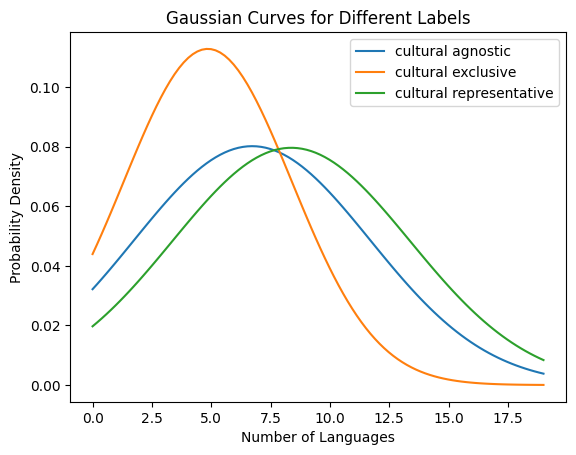

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

label_stats = filtered_language_df.groupby('label')['num_languages'].agg(['mean', 'std'])

# Create a range of x-values for the Gaussian curve
x = np.linspace(filtered_language_df['num_languages'].min(), filtered_language_df['num_languages'].max(), 100)

# Iterate through labels and plot the Gaussian curve for each
for label in label_stats.index:
    mean = label_stats.loc[label, 'mean']
    std = label_stats.loc[label, 'std']

    # Calculate the Gaussian probability density function (PDF)
    y = stats.norm.pdf(x, mean, std)

    # Plot the Gaussian curve
    plt.plot(x, y, label=label)

plt.legend()
plt.xlabel('Number of Languages')
plt.ylabel('Probability Density')
plt.title('Gaussian Curves for Different Labels')
plt.show()

[
'Q204':{
  'name': 'stringa'
'categories':{
  'C100': 'stringa',
  'C200': 'stringa',
  ...
}
'properties':{
  'P100': 'stringa',
  'P200': 'stringa',
  ...
}
]


}